## **Imports**

In [21]:
import tensorflow as tf
import matplotlib.pylab as plt
import random
from imblearn.over_sampling import SMOTE
import numpy as np

## **Parse TFRecords**

In [22]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    rec = tf.io.parse_single_example(proto, feature_description)
    shape = tf.sparse.to_dense(rec['shape'])
    img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
    label = rec['label']
    return img, label

file_patterns = ['data/train_images.tfrecords', 'data/val_images.tfrecords', 'data/test_images.tfrecords'] 

train_dataset = tf.data.TFRecordDataset(file_patterns[0])
train_dataset = train_dataset.map(parse_tfr)

val_dataset = tf.data.TFRecordDataset(file_patterns[1]) 
val_dataset = val_dataset.map(parse_tfr)

test_dataset = tf.data.TFRecordDataset(file_patterns[2]) 
test_dataset = test_dataset.map(parse_tfr)


In [23]:
NUM_TRAIN = sum(1 for _ in train_dataset)
NUM_VAL = sum(1 for _ in val_dataset)
NUM_TEST = sum(1 for _ in test_dataset)

print(f">> Number of examples in the training dataset: {NUM_TRAIN}")
print(f">> Number of examples in the validation dataset: {NUM_VAL}")
print(f">> Number of examples in the test dataset: {NUM_TEST}")

>> Number of examples in the training dataset: 2987
>> Number of examples in the validation dataset: 1280
>> Number of examples in the test dataset: 1


## **Resize Images**

In [24]:
image_size_counts = {}

# Count the occurrences of each image size
for idx, (image, label_int) in enumerate(train_dataset):
    image_size = (image.shape[0], image.shape[1])
    
    if image_size in image_size_counts:
        image_size_counts[image_size] += 1
    else:
        image_size_counts[image_size] = 1

# Print out top 5 occuring image sizes
sorted_sizes = sorted(image_size_counts.items(), key=lambda x: x[1], reverse=True)

for size, count in sorted_sizes[:5]:
    print(f"Image Size {size[0]}x{size[1]} occurred {count} times")

Image Size 300x300 occurred 2683 times
Image Size 295x221 occurred 10 times
Image Size 292x219 occurred 8 times
Image Size 221x295 occurred 7 times
Image Size 296x222 occurred 7 times


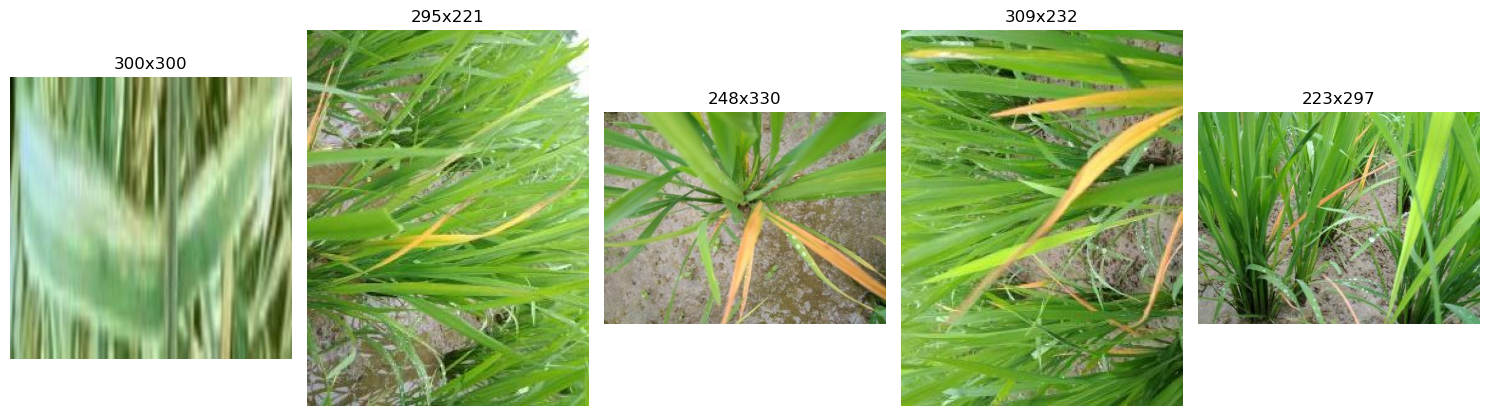

In [25]:
# Find pics with different size
different_sized_images = []
different_sized_indices = [] 
unique_sizes = set()

for idx, (image, label_int) in enumerate(train_dataset):
    image_size = (image.shape[0], image.shape[1])
    
    if image_size not in unique_sizes:
        different_sized_images.append(image)
        different_sized_indices.append(idx) 
        unique_sizes.add(image_size)
    
    if len(unique_sizes) >= 5:
        break 

# Display different Images
fig, ax = plt.subplots(1, len(different_sized_images), figsize=(15, 15))

for idx, image in enumerate(different_sized_images):
    ax[idx].imshow(image.numpy())
    ax[idx].set_title('{}x{}'.format(image.shape[0], image.shape[1]))
    ax[idx].axis('off')

plt.tight_layout()
plt.savefig(f"IMG/org_size.png")
plt.show()


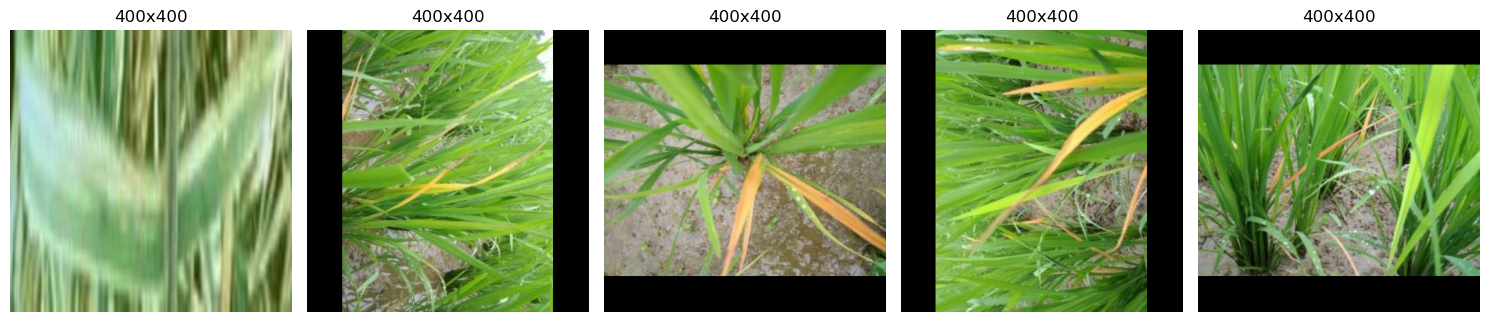

In [26]:
IMG_HEIGHT = 300
IMG_WIDTH = 300
IMG_CHANNELS = 3
IMAGE_SIZE = [IMG_HEIGHT, IMG_WIDTH]

preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 400, 400),
                           input_shape=(None, None, 3)),
    #tf.keras.layers.experimental.preprocessing.CenterCrop(
    #    height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

# Update Datasets
train_dataset = train_dataset.map(apply_preproc)
val_dataset = val_dataset.map(apply_preproc)
test_dataset = test_dataset.map(apply_preproc)

# Display different Images
fig, ax = plt.subplots(1, len(different_sized_indices), figsize=(15, 15))

for idx, image_idx in enumerate(different_sized_indices):
    # Retrieve the resized image using the stored index
    resized_image = next(image for i, (image, label_int) in enumerate(train_dataset) if i == image_idx)
    
    ax[idx].imshow(resized_image.numpy())
    ax[idx].set_title('{}x{}'.format(resized_image.shape[0], resized_image.shape[1]))
    ax[idx].axis('off')

plt.tight_layout()
plt.savefig(f"IMG/pad_size.png")
plt.show()

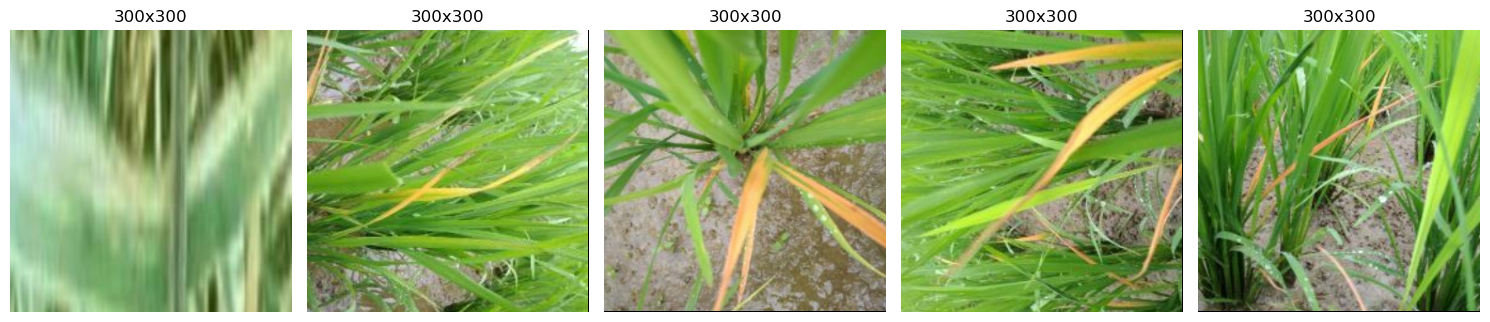

In [27]:
IMG_HEIGHT = 300
IMG_WIDTH = 300
IMG_CHANNELS = 3
IMAGE_SIZE = [IMG_HEIGHT, IMG_WIDTH]

preproc_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

# Update Datasets
train_dataset = train_dataset.map(apply_preproc)
val_dataset = val_dataset.map(apply_preproc)
test_dataset = test_dataset.map(apply_preproc)

# Display different Images
fig, ax = plt.subplots(1, len(different_sized_indices), figsize=(15, 15))

for idx, image_idx in enumerate(different_sized_indices):
    # Retrieve the resized image using the stored index
    resized_image = next(image for i, (image, label_int) in enumerate(train_dataset) if i == image_idx)
    
    ax[idx].imshow(resized_image.numpy())
    ax[idx].set_title('{}x{}'.format(resized_image.shape[0], resized_image.shape[1]))
    ax[idx].axis('off')

plt.tight_layout()
plt.savefig(f"IMG/cropped_size.png")
plt.show()

## **Data Augmentation**

### **Flipping**

# Define the function to apply flips
def apply_flipping(img, label):
    random_number = random.randint(0, 100)
    # apply horizontal
    if random_number < 33:
        img = tf.image.flip_left_right(img) 
    # apply vertically
    elif random_number < 66:
        img = tf.image.flip_up_down(img) 
    # apply both
    else:
        img = tf.image.flip_left_right(img) 
        img = tf.image.flip_up_down(img) 
    return img, label

# Take 25% of random training samples to flip
shuffled_train_dataset = train_dataset.shuffle(buffer_size=NUM_TRAIN)

new_samples = NUM_TRAIN // 1
data_to_flip = shuffled_train_dataset.take(new_samples)

# Apply the flipping function to the random training data
flipped_data = data_to_flip.map(apply_flipping)

# Add flipped data to the training data samples
combined_train_dataset = train_dataset.concatenate(flipped_data)

# shuffle the new combined training dataset
train_dataset = combined_train_dataset.shuffle(buffer_size=NUM_TRAIN * 4)


# Function to plot original and flipped images from a dataset
def plot_images_with_labels(dataset, num_images=6):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Plot original image
        plt.subplot(2, num_images, 2 * i + 1)
        plt.imshow(image.numpy())
        plt.title('Original')
        plt.axis('off')
        
        # Plot flipped image
        plt.subplot(2, num_images, 2 * i + 2)
        flipped_image, _ = apply_flipping(image, label)  
        plt.imshow(flipped_image.numpy())
        plt.title('Flipped')
        plt.axis('off')
        
    plt.show()

plot_images_with_labels(data_to_flip)


print(f"""
      ---> Training Dataset <---

         before: {NUM_TRAIN}
         new samples: {new_samples}  
         after: {NUM_TRAIN + new_samples}

      """)

NUM_TRAIN += new_samples


### **Adjust Brightness**

# same concept as applied to the flipped images
def apply_brightness(img, label):
    random_number = random.randint(0, 100)

    if random_number < 50:
        random_brightness = random.uniform(0.1, 0.3)
    else:
        random_brightness = random.uniform(-0.3, -0.1)
        
    img = tf.image.adjust_brightness(img, delta=random_brightness)
    return img, label

shuffled_train_dataset = train_dataset.shuffle(buffer_size=NUM_TRAIN)

new_samples = NUM_TRAIN // 1
data_to_change_brightness = shuffled_train_dataset.take(new_samples)

brightness_data = data_to_change_brightness.map(apply_preproc)
combined_train_dataset = train_dataset.concatenate(brightness_data)
train_dataset = combined_train_dataset.shuffle(buffer_size=NUM_TRAIN * 2)

def plot_images_with_labels(dataset, num_images=6):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Plot original image
        plt.subplot(2, num_images, 2 * i + 1)
        plt.imshow(image.numpy())
        plt.title('Original')
        plt.axis('off')
        
        # Plot flipped image
        plt.subplot(2, num_images, 2 * i + 2)
        flipped_image, _ = apply_brightness(image, label)  
        plt.imshow(flipped_image.numpy())
        plt.title('Changed')
        plt.axis('off')
        
    plt.show()

plot_images_with_labels(data_to_change_brightness)


print(f"""
      ---> Training Dataset <---

         before: {NUM_TRAIN}
         new samples: {new_samples}  
         after: {NUM_TRAIN + new_samples}

      """)

NUM_TRAIN += new_samples

## **Create Preprocessed TFRecords**

In [28]:
def serialize_example(image, label):
    image = tf.cast(image * 255.0, tf.uint8)
    
    feature = {
        'image': tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
        'label': tf.train.Feature(
            int64_list=tf.train.Int64List(value=[label])),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    example_bytes = example.SerializeToString()
    return example_bytes

# Define new TFRecord file paths for saving
output_train_tfrecord_file = 'data/preprocessed_train_images.tfrecords'
output_val_tfrecord_file = 'data/preprocessed_val_images.tfrecords'
output_test_tfrecord_file = 'data/preprocessed_test_images.tfrecords'

# Serialize and write examples to the new TFRecord file for the training dataset
with tf.io.TFRecordWriter(output_train_tfrecord_file) as train_writer:
    for img, label in train_dataset:
        example_bytes = serialize_example(img, label)
        train_writer.write(example_bytes)

# Serialize and write examples to the new TFRecord file for the validation dataset
with tf.io.TFRecordWriter(output_val_tfrecord_file) as val_writer:
    for img, label in val_dataset:
        example_bytes = serialize_example(img, label)
        val_writer.write(example_bytes)

# Serialize and write examples to the new TFRecord file for the test dataset
with tf.io.TFRecordWriter(output_test_tfrecord_file) as test_writer:
    for img, label in test_dataset:
        example_bytes = serialize_example(img, label)
        test_writer.write(example_bytes)

## **Display Preprocessed Images**

In [29]:
"""
plt.figure(figsize=(15, 10))

# Initialize an iterator to loop through the dataset
iterator = iter(train_dataset)

# Iterate and plot the first 20 images
for i in range(20):
    img, label = next(iterator)  # Get an image and label
    img = img.numpy()  # Convert the TensorFlow tensor to NumPy array
    label = label.numpy()  # Convert the TensorFlow tensor to NumPy array

    plt.subplot(5, 4, i + 1)  # Create a subplot with a 5x4 grid
    plt.imshow(img)  # Display the image
    plt.title(f'Label: {label}')  # Display the label as the title

plt.tight_layout()
plt.show()
"""

"\nplt.figure(figsize=(15, 10))\n\n# Initialize an iterator to loop through the dataset\niterator = iter(train_dataset)\n\n# Iterate and plot the first 20 images\nfor i in range(20):\n    img, label = next(iterator)  # Get an image and label\n    img = img.numpy()  # Convert the TensorFlow tensor to NumPy array\n    label = label.numpy()  # Convert the TensorFlow tensor to NumPy array\n\n    plt.subplot(5, 4, i + 1)  # Create a subplot with a 5x4 grid\n    plt.imshow(img)  # Display the image\n    plt.title(f'Label: {label}')  # Display the label as the title\n\nplt.tight_layout()\nplt.show()\n"